In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image

import flickr_api
from flickr_api import Photo
from sklearn.cluster import DBSCAN

from dataset.load import LoadDataset
from dataset.utils import load_credentials, get_photo
from utils.vis import make_tensor, visualize_grid

api_key, api_secret = load_credentials()
flickr_api.set_keys(api_key=api_key, api_secret=api_secret)

In [3]:
# Load dataset and count number of photos
path = "data/paris_10000.h5"
dataset = LoadDataset(path)
print(dataset.size(), "photos")

4216 photos


In [4]:
# Get features from dataset
it = dataset.get()
X = []
for i, row in enumerate(it):
    metadata, embedding = row
    lat = float(metadata["location"]["latitude"])
    lon = float(metadata["location"]["longitude"])
    id = int(metadata["id"])
    X.append([id, lat, lon])

X = np.asarray(X)
X.shape

(4216, 3)

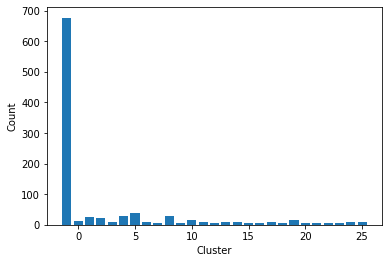

In [5]:
# Sampling on a smaller subset
train_idx = np.random.choice(X.shape[0], size=1000, replace=False)
sample = X[train_idx]
X_train = sample[:, 1:]

# Train clustering using DBSCAN
kms_per_radian = 6371.0088
meters = 50
epsilon = (meters * 0.001) / kms_per_radian
db = DBSCAN(eps=epsilon, algorithm='ball_tree', metric='haversine')
db.fit(np.radians(X_train))
y_train = db.labels_
fig, ax = plt.subplots()
ax.bar(*np.unique(y_train, return_counts=True))
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
plt.show()

In [6]:
# Get images in clusters
cluster_imgs = {}
for label in set(y_train):
    if label == -1: continue
    photos_id = sample[y_train == label, 0]
    cluster_imgs[label] = []
    subset = np.random.choice(photos_id.shape[0], size=min(photos_id.shape[0], 4), replace=False)
    for photo_id in photos_id[subset]:
        p = Photo(id=photo_id)
        img = get_photo(p)
        cluster_imgs[label].append(img)

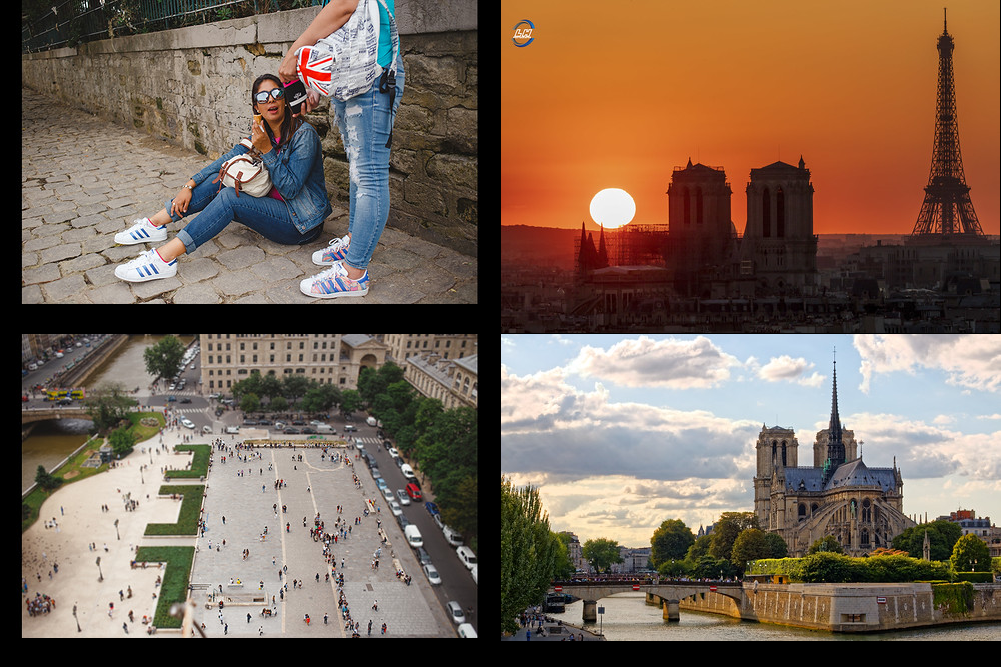

In [7]:
# Visualize photos from the same cluster
cluster_label = 0
grid = visualize_grid(make_tensor(cluster_imgs[cluster_label]))
Image.fromarray(grid.astype("uint8"))

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cluster_sim(X):
    embedding_X = [dataset.get_id(int(photo_id))[1] for photo_id in X[:, 0]]
    embedding_X = np.stack(embedding_X, axis=0)
    return cosine_similarity(embedding_X).mean()

# Quantitative measure of the clusters
cluster_similarities = {}
for label in set(y_train):
    if label == -1: continue
    cluster_X = sample[y_train == label]
    cluster_sim = compute_cluster_sim(cluster_X)
    cluster_similarities[label] = cluster_sim

cluster_similarities

{0: 0.69891334,
 1: 0.71666014,
 2: 0.67446965,
 3: 0.83185875,
 4: 0.68646383,
 5: 0.6656056,
 6: 0.634196,
 7: 0.8248368,
 8: 0.5878613,
 9: 0.72693205,
 10: 0.7141164,
 11: 0.6726273,
 12: 0.74225926,
 13: 0.8422449,
 14: 0.6608725,
 15: 0.62816566,
 16: 0.84988725,
 17: 0.661709,
 18: 0.68369275,
 19: 0.6243181,
 20: 0.7474711,
 21: 0.7023776,
 22: 0.7724786,
 23: 0.7384874,
 24: 0.72461474,
 25: 0.6683522}

In [11]:
df = pd.DataFrame()
for label in set(y_train):
    if label == -1: continue
    photos_id = sample[y_train == label, 0]
    for photo_id in photos_id:
        metadata, _ = dataset.get_id(int(photo_id))
        df = df.append({
            "lat": float(metadata["location"]["latitude"]),
            "lon": float(metadata["location"]["longitude"]),
            "id": metadata["id"],
            "title": str(metadata["title"])[:35] if "title" in metadata.keys() else "(No title)",
            "cluster": int(label)
        }, ignore_index=True)
df.head()

,cluster,id,lat,lon,title
0,0.0,33740484935,48.853237,2.349636,Ana & Vania | London & Paris | Clau
1,0.0,36626361426,48.853130,2.349013,The River Seine and the spring Pari
2,0.0,46824814304,48.853079,2.350018,Paris Cityscape Deux 1989
3,0.0,32897542254,48.853237,2.349636,Ana & Vania | London & Paris | Clau
4,0.0,37169517081,48.853130,2.349013,View to Seine from Notre-Dame de Pa


In [12]:
from geojsonio import embed
from utils.geojson import GeoJson

geojson_data = GeoJson().to_geojson(df, 
    'cluster', # column for grouping to the same pin color
    'lat', # latitude column name
    'lon', # longitude column name
    [c for c in df.columns] # metadata to add in the geojson
)
geojson_data.save_to("geojson-viewer/data.geojson")